<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Permeability_from_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [2]:
!pip install GitPython
from git import Repo
# !git clone https://github.com/MariiaKalinina/Elasticity.git
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElasticity_v1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00
Cloning into 'NewElasticity_v1'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 368 (delta 170), reused 114 (delta 73), pack-reused 100
Receiving objects: 100% (368/368), 17.00 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [3]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [6]:
data.dropna(subset=['AR thermal'], inplace=True)

In [7]:
data[:10]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical,Unnamed: 17,Unnamed: 18,TC air,TC oil,"TC 0,6",TC 6,TC 60,TC 180
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,NaN,2.472888,2.668885,NaN,2.740225,2.966438,2.852613
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,NaN,2.404575,2.600888,2.745500,2.741125,2.857375,2.834588
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,NaN,1.858550,2.234582,2.535225,2.514712,2.630950,2.677875
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,NaN,1.867175,2.286873,2.619337,2.604425,2.728613,2.715700
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,2.123563,2.400862,2.661125,2.623087,2.823100,2.718675
5,113566,a,пористо-кавернозный,9.294073,79.117000,2.462813,2.453298,3.756667,2.222333,4.699830,2.492100,4.8885,2.7235,NaN,0.144544,0.063096,NaN,NaN,2.244775,2.456700,2.659225,2.679425,2.746012,2.825363
6,113572,a,пористо-кавернозный,8.824133,32.488200,2.473036,2.462001,3.847333,2.278000,5.103325,2.809800,4.9355,2.6325,NaN,0.149968,0.072444,NaN,NaN,2.267150,2.526250,2.644188,2.700200,2.843925,2.802163
7,113577,a,"пористо-кавернозный, частично перекристаллизованный, скол на торце",7.476561,1.130080,2.514214,2.506365,3.716667,2.083333,4.972040,2.834515,4.8885,2.5050,NaN,0.120226,0.079433,NaN,NaN,2.297250,2.571282,2.732938,2.763263,2.936562,2.838300
9,113603,a,"пористо-кавернозный, частично перекристаллизованный, неравномерная пористость, открытые трещины",6.812695,0.399309,2.538758,2.535101,4.065667,2.212000,5.177195,2.813970,4.9000,2.4710,NaN,0.158489,0.069183,NaN,NaN,2.342800,2.721150,2.935987,2.931387,2.992613,3.003312
10,113619,a,пористо-кавернозный,8.326070,2.446320,2.478543,2.476065,4.154333,2.432000,4.983580,2.704390,4.9835,2.5480,NaN,0.124738,0.071340,NaN,NaN,2.252275,2.528852,2.710038,2.731038,2.823150,2.810587


In [8]:
df_ues['Permeability'].min(), df_ues['Permeability'].max()

(0.0169466, 2393.99)

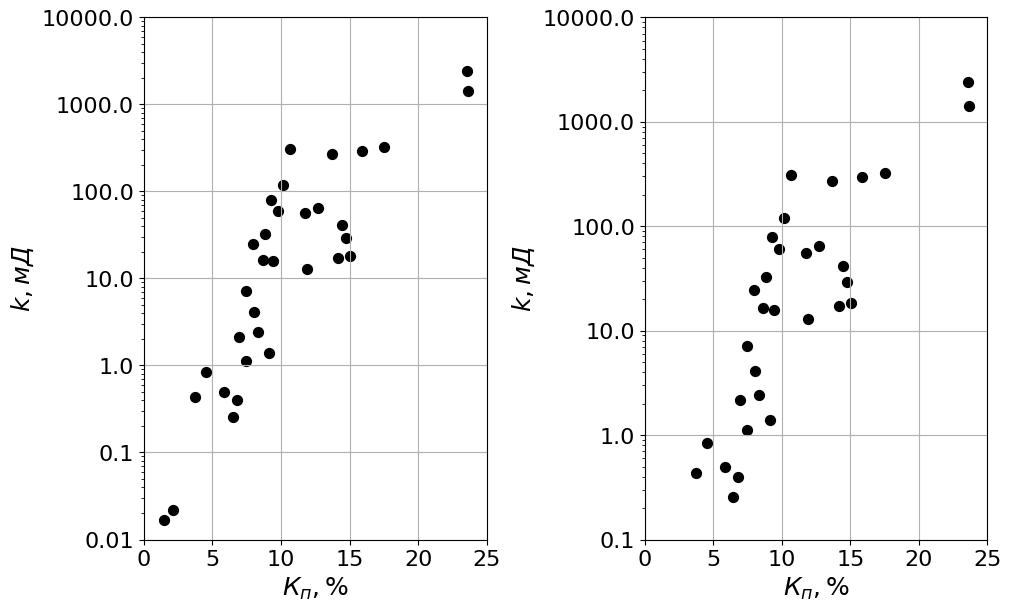

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
# layout='constrained'
# fig.tight_layout(pad=0.001000)
axs = fig.subplots(1, 2,  sharex=False)

ticks_size, label_size = 16, 18

        ### Porosity VS Permeability (all samples)
x_value, y_value = "Porosity,%", "Permeability"

  ### INPUT DATA
axs[0].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[0].set_xscale("linear")
axs[0].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[0].set_xlim([0, 25])
axs[0].set_xticks(np.arange(0, 26, 5))
axs[0].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

axs[0].set_yscale('log')
axs[0].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[0].set_ylim([10**-2, 10**4])
axs[0].set_yticks(np.logspace(-2, 4, num=7))
axs[0].set_yticklabels(np.logspace(-2, 4, num=7), fontsize=ticks_size)



  ### INPUT DATA - 2
axs[1].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[1].set_xscale("linear")
axs[1].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[1].set_xlim([0, 25])
axs[1].set_xticks(np.arange(0, 26, 5))
axs[1].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[1].set_yscale('log', base=10)
axs[1].grid(which='major', axis='both', linestyle='-')

axs[1].set_yscale('log')
axs[1].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[1].set_ylim([10**-1, 10**4])
axs[1].set_yticks(np.logspace(-1, 4, num=6))
axs[1].set_yticklabels(np.logspace(-1, 4, num=6), fontsize=ticks_size)


plt.show()

Границы ХШ

In [10]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

# Self-consistent (GSA)

ОСП - теплопроводность, проницаемость

In [ ]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


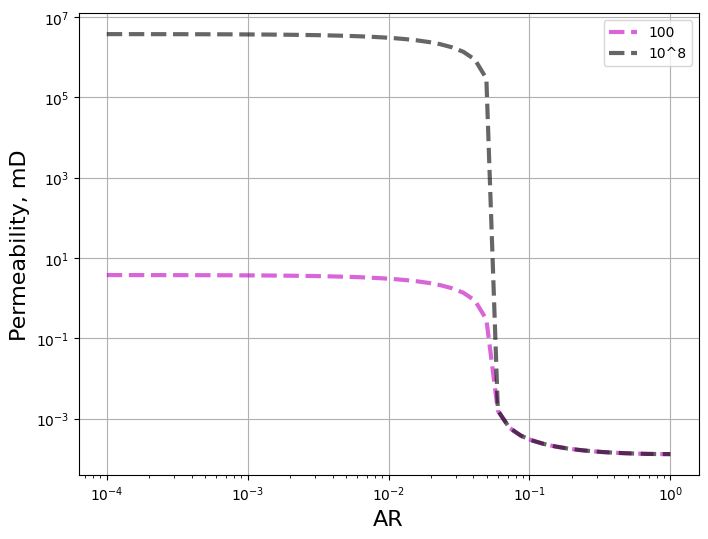

In [ ]:
ar_inclusion_list = np.logspace(-4, 0, num=50, base=10)
porosity = 0.08

calculation_perm_1, calculation_perm_2 =[], []

for ar_inclusion in ar_inclusion_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_inclusion]
  calculation_perm_1.append(effective_tc(conc, alpha_shape, [10**-4, 10**2]))
  calculation_perm_2.append(effective_tc(conc, alpha_shape, [10**-4, 10**8]))

fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(ar_inclusion_list, calculation_perm_1, 'm--', lw=3, alpha=0.6, label='100')
axs.plot(ar_inclusion_list, calculation_perm_2, 'k--', lw=3, alpha=0.6, label='10^8')
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability, mD', fontsize=16)
axs.set_xlabel('AR', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

Анализ чувствительности «Матричная» проницаемость к АО пор (оценка по диапазону АО, инвертированному по теплопроводности: 0.07-0.28)

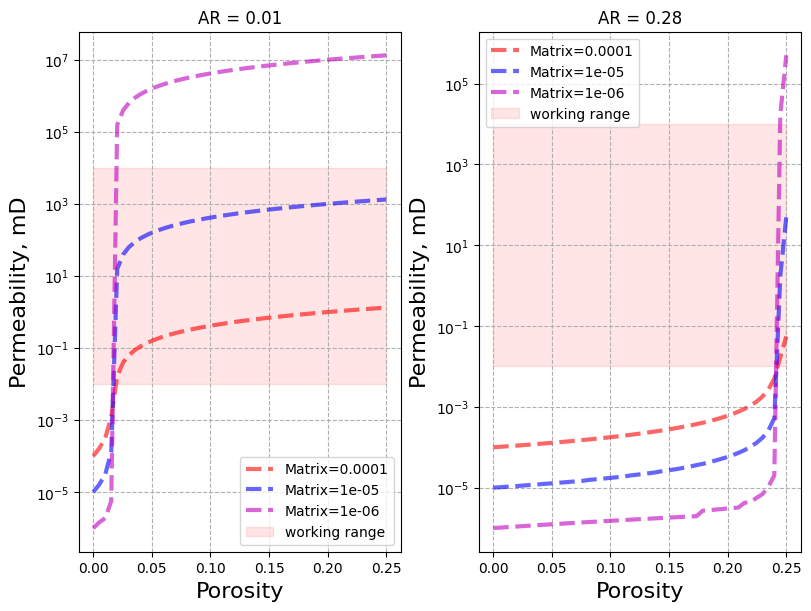

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity

    alpha_shape = [1, ar_fluid]

    mlam = [10**-4, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-5, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-6, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

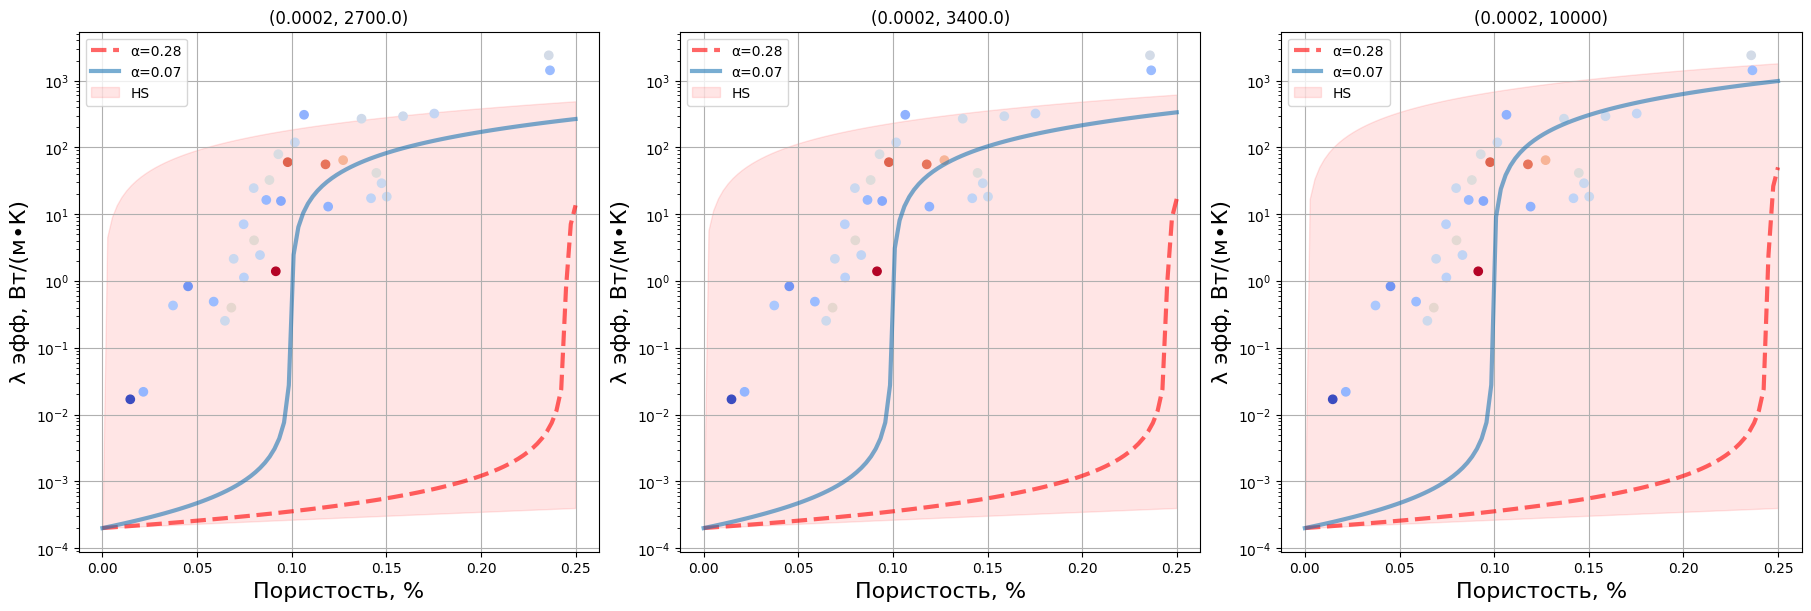

In [ ]:

fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 2.7*1000),
              (mtrx_perm, 3.4*1000),
              (mtrx_perm, 10**4)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

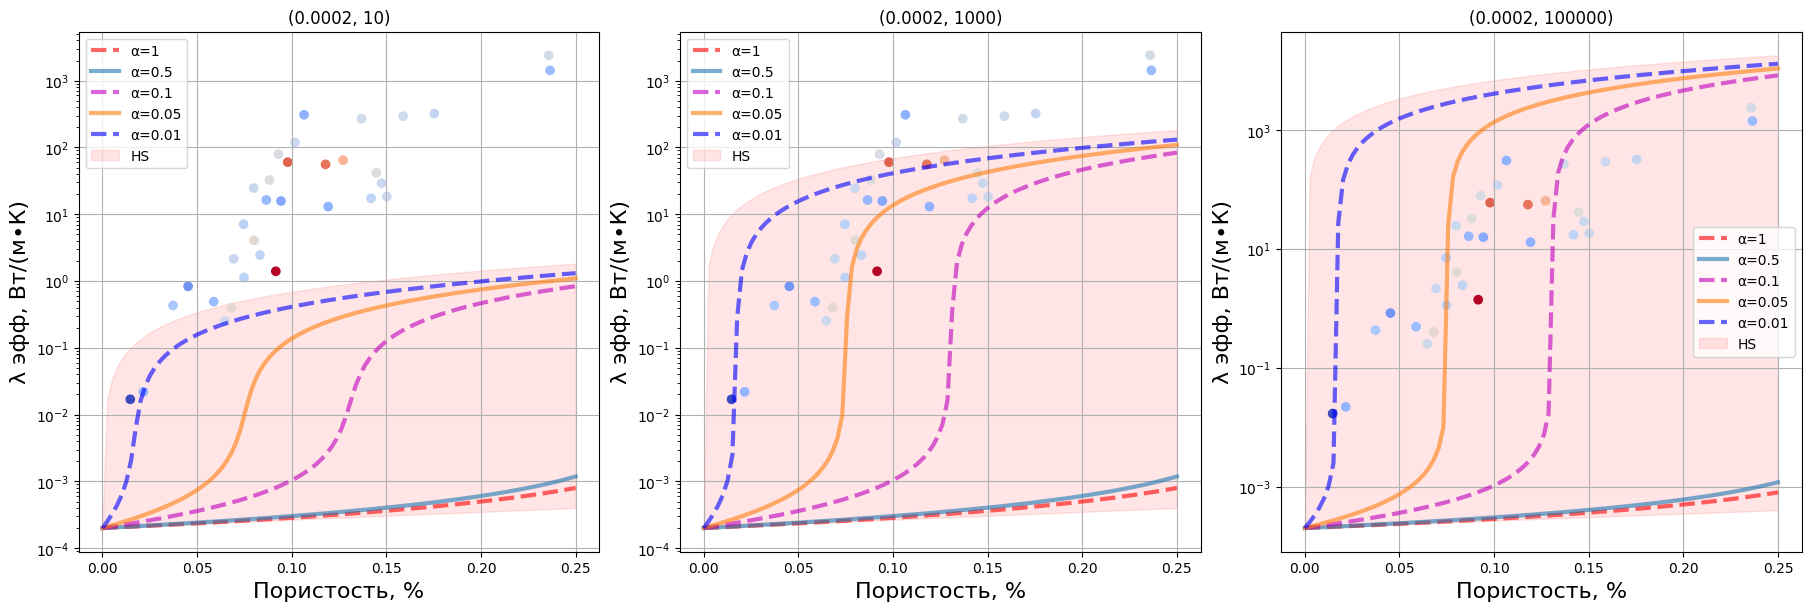

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**1),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**5)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 1]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.5]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.1]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.05]
    for i in por:
        conc = [1-i, i]
        ar1.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.01]
    for i in por:
        conc = [1-i, i]
        ar2.append(effective_tc(conc, alpha_shape, mlam))

    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=1')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.5')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.1')
    ax.plot(por, ar1, lw=3, alpha=0.6, label='α=0.05')
    ax.plot(por, ar2,'b--', lw=3, alpha=0.6, label='α=0.01')




    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

Решение обратной задачи

In [ ]:
idx = 0
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]/3
mtrx_perm = 2*10**-4

In [ ]:
porosity, exp_permeability, ar_pore, ar_pore_initial

(0.045249, 0.832741, 0.022227, 0.066681)

In [ ]:
fluid_perm_list = np.logspace(1, 5, num=40, base=10)

calculation_perm =[]

for fluid_comp_perm in fluid_perm_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_pore]
  components = [mtrx_perm, fluid_comp_perm]
  calculation_perm.append(effective_tc(conc, alpha_shape, components))

In [ ]:

results = pd.DataFrame()
results['Fluid perm'] = fluid_perm_list
results['Calculatioin perm'] = calculation_perm

results['Diff'] = results['Calculatioin perm'].apply(lambda x: abs(np.round((x-exp_permeability)/exp_permeability*100, 2)))

In [ ]:
results = results.sort_values(by=f'Diff')

In [ ]:
results[:3]

,Fluid perm,Calculatioin perm,Diff
13,215.443469,0.928042,11.44
12,170.125428,0.733142,11.96
11,134.339933,0.579238,30.44


### Вывод

## Анализ чувствительности
Рассматривая диапазон изменения проницаемости (k) от $10^{-2}$ до $10^{4}$ мД, изменения $k_{matrix}$ не влияют на эффективное значение, поэтому используем одно фиксированное значение $k_{matrix}$=0.0002 мД из уравнения регресиии "Пористость - Пронициемость".

$k_{fluid}$ в большей степени влияет на эффективное значение, однако начиная с $k_{fluid}$ > $10^{6}$, эффективное значение для $AR_{thermal}$: 0.07 - 0.28 не изменяется. Поэтому рассматриваем $k_{fluid}$ в диапазоне от $10^{0}$ до $10^{6}$ мД.

Рассчитать эффективную проницаемость с использованием $AR_{thermal}$: 0.07 - 0.28 не удалось. Если смотреть на анализ чувствительности, то видно, что кривые для разных $AR_{thermal}$ не попадают на экспериментальные значениея проницаемости. Однако, если занизить систематически $AR_{thermal}$ в 3 раза и больше (т.е. $AR_{thermal}$: 0.01 - 0.05), то можно получить приемлемые решения (погрешность 10%) для эффективного k.

Можно ли вообще использовать модель ОСП? Очень странное поведение модели: уменьшение эффективной проницаемости с увеличением АО, при этом на маленьких АО, эффективная проницаемость растет

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data_ml = data[['Porosity,%', 'AR thermal', 'TC air','TC oil', 'TC 6', 'TC 60', 'TC 180', 'Permeability']]
data_ml.dropna(inplace=True)

target = data_ml ['Permeability']

<ipython-input-23-35f8357ce9db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.dropna(inplace=True)


In [ ]:
### BEGIN Solution (do not delete this comment)
X, y = data_ml.iloc[:, :-1], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0xC0FFEE)
### END Solution (do not delete this comment)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features =list(X.columns)

X_train[features] = scaler.fit_transform(X_train[list(features)])
X_test[features] = scaler.fit_transform(X_test[list(features)])

In [ ]:
### BEGIN Solution

lin_reg = []

MODELS = {
    "Linear Regression": LinearRegression(),
    "Ridge regression" : Ridge(),
    "DecisionTree" : DecisionTreeRegressor()
}

for name, model in MODELS.items():
  clf = model.fit(X_train,y_train)

  y_pred = clf.predict(X_train)
  print(f'Trian RMSL {name}: {mse(y_train, y_pred):.2f}')

  if name=='Linear Regression':
    y_pred = clf.predict(X_test)
    lin_reg = y_pred

  y_pred = clf.predict(X_test)
  print(f'Test RMSL {name}: {mse(y_test, y_pred):.2f}', end='\n\n')

### END Solution

Trian RMSL Linear Regression: 2390.56
Test RMSL Linear Regression: 633942.79

Trian RMSL Ridge regression: 3105.12
Test RMSL Ridge regression: 682398.18

Trian RMSL DecisionTree: 0.00
Test RMSL DecisionTree: 601346.13



In [ ]:
clf = LinearRegression().fit(X_train,y_train)
lin = clf.predict(X)

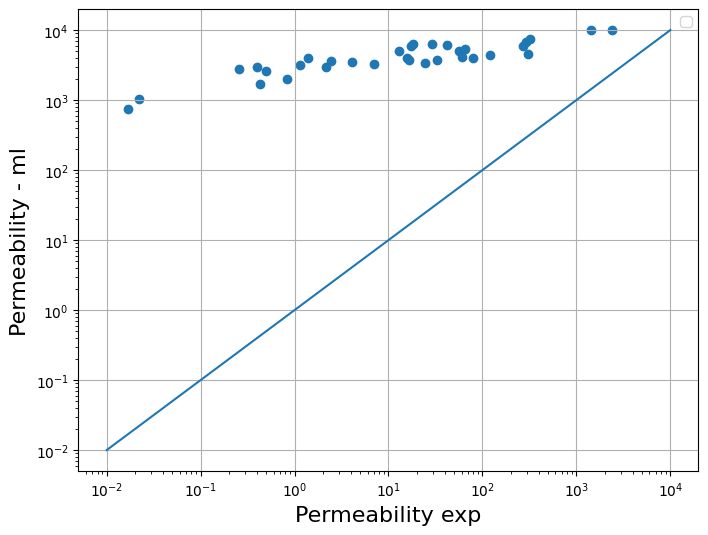

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.scatter(target, lin)
axs.plot([10**-2, 10**4], [10**-2, 10**4])
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability - ml', fontsize=16)
axs.set_xlabel('Permeability exp', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

# f-модель

In [22]:
def effective_tc_f(conc, alpha_shape, lam, f):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]*(1-f) + lam[1]*f

    parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

    for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all # числитель
        t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

        parall_comp.append(t16)  # числитель формулы (матрица, флюид)
        perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

    L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
    return L_eff

### Plot "Porosity - Thermal conductivity with dependecence from f'

In [11]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  eff_tc = []

  for porosity in np.linspace(0, 0.1, N):

    conc = [1-porosity, porosity]
    alpha_shape = [1, 0.01]
    mlam = [3, 0.025]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))

  plt.plot(np.linspace(0, 1, N),  eff_tc, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
plt.ylim(0,3)
plt.grid()
plt.title('Porosity - Thermal conductivity with dependecence from f')


NameError: name 'effective_tc_f' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, y, z are your data arrays
x = np.linspace(0, 1, 100)
y = np.logspace(-4, 0, 100, base=10)
z = 3 * x / (4 * np.pi * y)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('Porosity')
ax.set_ylabel('log(AR)')
ax.set_zlabel('e')



# Adjust viewing angle
# ax.view_init(azim=40)

plt.show()

In [ ]:
for porosity in np.linspace(0, 1, 6):

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{porosity}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend()

In [ ]:
# for porosity in np.linspace(0, 0.25, 3):
for porosity in [0.05, 0.1, 0.15, 0.2, 0.25]:

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{porosity}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend()

### Sensetive study

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar = 0.13
lam_matrix = 10**-4

lam_fluid=[10**2, 10**4]

for ax, l_fluid in zip(axs,lam_fluid):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    list1, list2, list3 = [], [], []
    por = porosity

    alpha_shape = [1, ar]

    mlam = [lam_matrix, l_fluid]

    f=0.05
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.1
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.15
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')


    f=0.2
    for i in por:
        conc = [1-i, i]
        list1.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list1, lw=3, alpha=0.6, label=f'f={f}')


    f=0.4
    for i in por:
        conc = [1-i, i]
        list2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list2, lw=3, alpha=0.6, label=f'f={f}')


    f=0.6
    for i in por:
        conc = [1-i, i]
        list3.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list3, lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    ax.set_ylim([10**0, 10**4])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'ki fluid = {l_fluid}, AR=0.13')

plt.show()

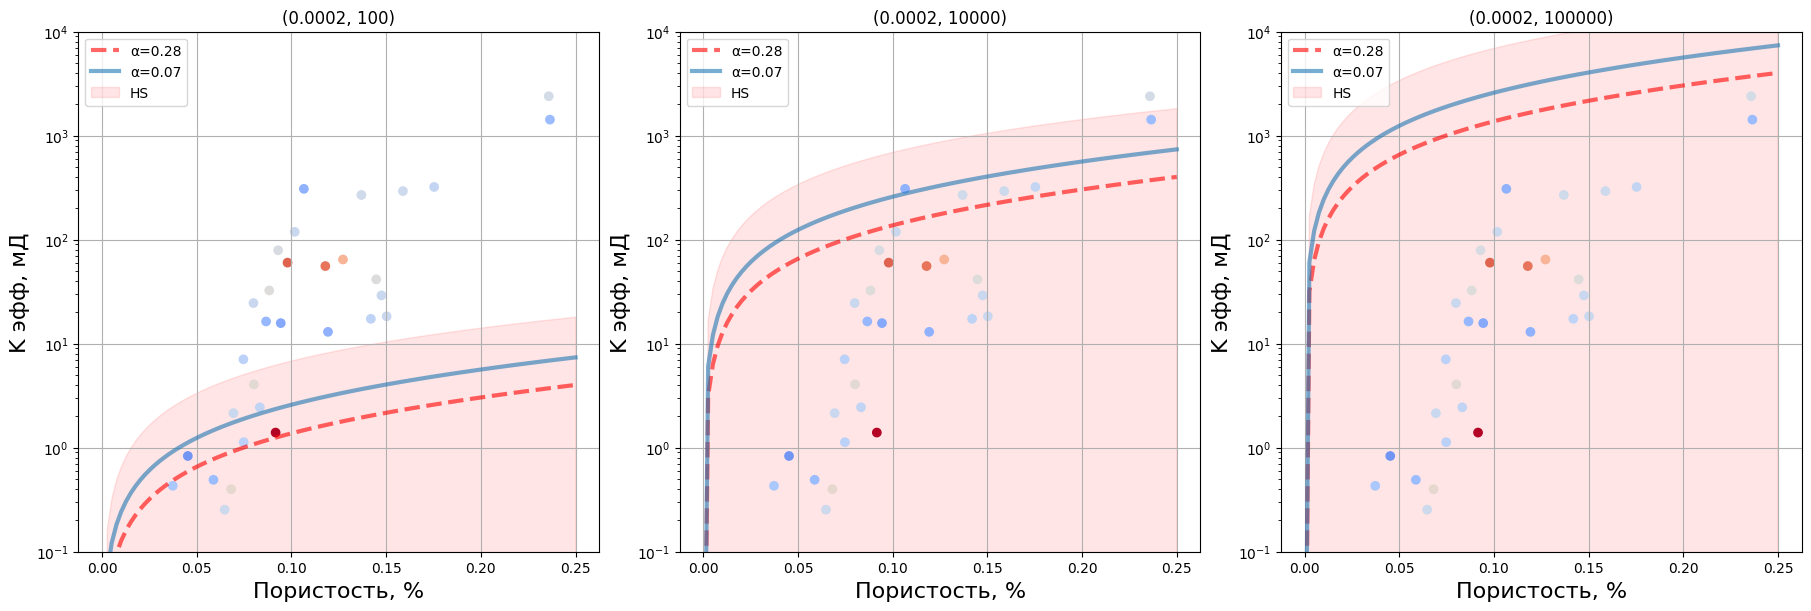

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**4),
              (mtrx_perm, 10**5)]

f=0.05

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('K эфф, мД', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-1, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

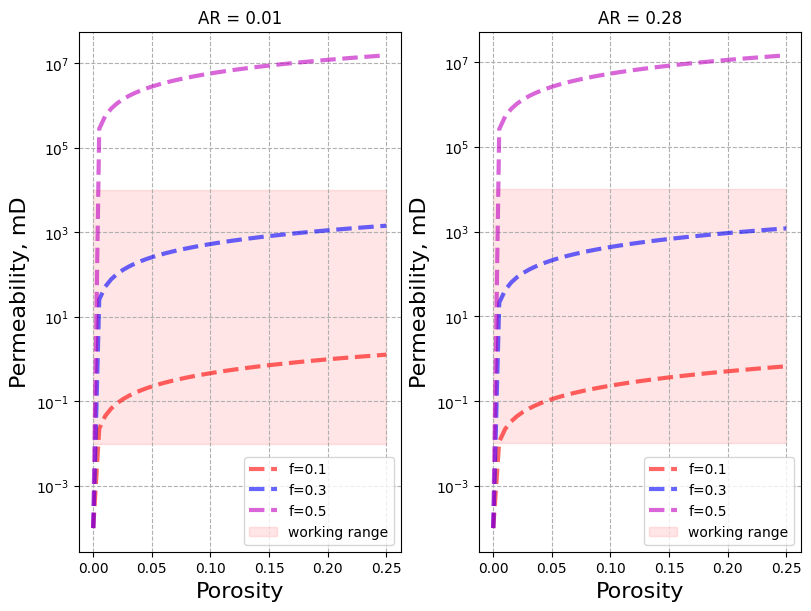

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)
matrix = 10**-4

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):


    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity
    alpha_shape = [1, ar_fluid]

    f = 0.1
    mlam = [matrix, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.3
    mlam = [matrix, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.5
    mlam = [matrix, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

### Inverse problem

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
idx = 14
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]
mtrx_perm = 2*10**-4

In [ ]:
print(porosity,ar_pore)

0.09789559467455616 0.242103


In [ ]:
### Ограничение на максимальное значение параметр связаности f через уравнение уравнение Козени– Кармана, о связи пористости и проницаемости
kmin, kmax, kreal = 0.0169466, 2393.99, exp_permeability
fmax = 1 - (np.log(kmax/kreal)/np.log(kmax/kmin))
print(f"fmax: {np.round(fmax, 2)}")
print(f"k/φ {np.round(kreal/porosity, 2)}")

fmax: 0.69
k/φ 614.51


In [ ]:
N = 200
fluid_perm_list = []
# f_list = np.linspace(0., fmax, N)
f_list = []
calculation_perm =[]

for fluid_comp_perm in np.logspace(1, 5, num=N, base=10):
  for f in np.linspace(0., 1, N):
    conc = [1-porosity, porosity]
    alpha_shape = [1, ar_pore]
    components = [mtrx_perm, fluid_comp_perm]
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))
    fluid_perm_list.append(fluid_comp_perm)
    f_list.append(f)

In [ ]:
results = pd.DataFrame()
results[f'Sample_{idx}'] = [data["Sample"][idx]]*N**2
results[f'Porosity_{idx}'] = [data["Porosity,%"][idx]]*N**2
results[f'Fluid perm_{idx}'] = fluid_perm_list
results[f'f_{idx}'] = f_list

results[f'Calculatioin perm_{idx}'] = calculation_perm
results[f'Expermental_{idx}'] = [exp_permeability]*len(calculation_perm)

### Байссовский подход
results[f'Diff_{idx}'] = abs((results[f'Calculatioin perm_{idx}'] - results[f'Expermental_{idx}'])/results[f'Expermental_{idx}']*100)
results['p(B|Ai)'] = np.exp(-results[f'Diff_{idx}']**2)
results['p(Ai|b)'] = np.exp(-results[f'Diff_{idx}']**2) / np.sum(results['p(B|Ai)'])

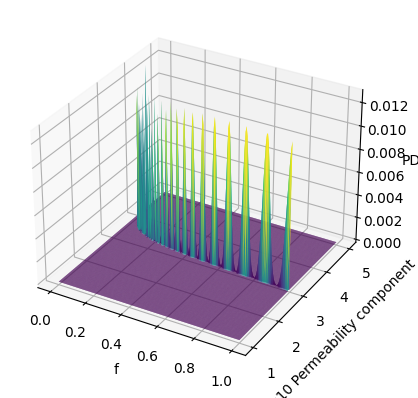

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x, y, z are your data arrays
x = results[f'f_{idx}']
y = np.log10(results[f'Fluid perm_{idx}'])
z = results['p(Ai|b)']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('f')
ax.set_ylabel('Lg10 Permeability component')
ax.set_zlabel('PDF')

plt.show()

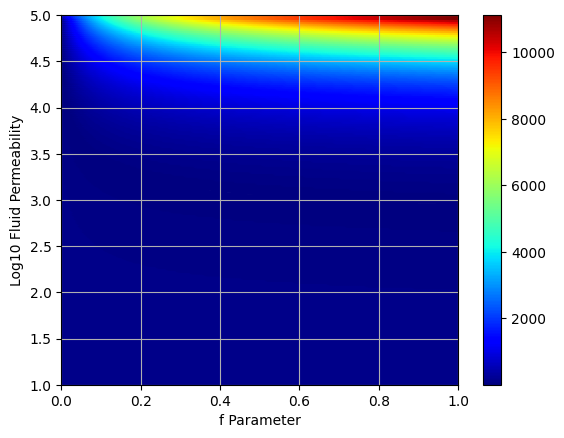

In [ ]:
scatter = plt.scatter(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']),
                      c=results[f'Diff_{idx}'], cmap='jet', marker='o')

# Apply a mask to the scatter plot
mask = results[f'Diff_{idx}'] < 8
scatter.set_array(np.ma.masked_where(mask, scatter.get_array()))

# Add color bar to the plot
plt.colorbar(scatter)

plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')
plt.xlim(0, 1)
plt.ylim(1, 5)

plt.grid()

plt.show()

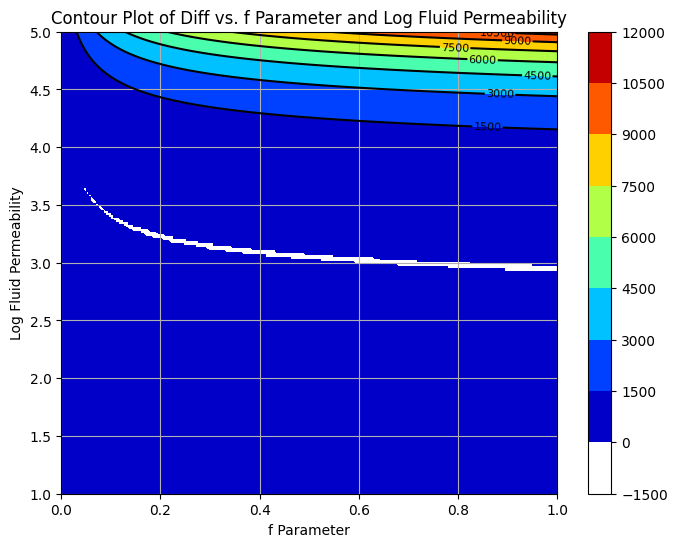

In [ ]:
plt.figure(figsize=(8, 6))
masked_diff_filled = np.where(results[f'Diff_{idx}'] < 8, -1, results[f'Diff_{idx}'])


cmap = plt.cm.jet
cmap.set_under('white')  # Set the color for the value -1 to white

contour = plt.tricontourf(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), masked_diff_filled, cmap=cmap, vmin=-1)


contour_lines = plt.tricontour(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), results[f'Diff_{idx}'], colors='k')
plt.clabel(contour_lines, inline=True, fontsize=8)  # Add labels to the isolines


plt.colorbar(contour)

plt.xlabel('f Parameter')
plt.ylabel('Log Fluid Permeability')
plt.title('Contour Plot of Diff vs. f Parameter and Log Fluid Permeability')
plt.grid(True)
plt.show()

In [ ]:
results = results.sort_values(by=f'Diff_{idx}')
filtered_results = results[results[f'Diff_{idx}'] < 8]
# Save the filtered results to an Excel file
filtered_results.to_excel(f'{data["Sample"][idx]}_{idx}.xlsx', index=False)
# filtered_results.to_csv(f'{data["Sample"][idx]}.csv', index=False)  # This will save the DataFrame to a CSV file without including the index

In [ ]:
filtered_results[:5]

,Sample_14,Porosity_14,Fluid perm_14,f_14,Calculatioin perm_14,Expermental_14,Diff_14,p(B|Ai),p(Ai|b)
21264,113726,9.789559,1350.993521,0.321608,60.159443,60.1577,0.002898,0.999992,0.012819
19950,113726,9.789559,977.124154,0.753769,60.176006,60.1577,0.030430,0.999074,0.012808
20131,113726,9.789559,1023.411402,0.658291,60.181600,60.1577,0.039730,0.998423,0.012799
32202,113726,9.789559,17225.859654,0.010050,60.130374,60.1577,0.045424,0.997939,0.012793
20315,113726,9.789559,1071.891319,0.577889,60.192707,60.1577,0.058191,0.996619,0.012776


Text(0.5, 0, 'Ki components, mD')

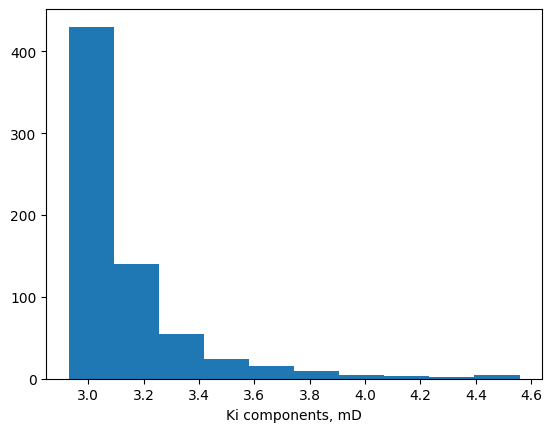

In [ ]:
plt.hist(np.log10(filtered_results[f'Fluid perm_{idx}']))
plt.xlabel('Ki components, mD')

Text(0.5, 0, 'f')

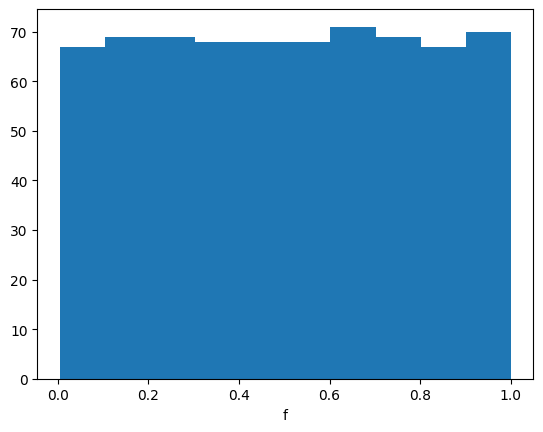

In [ ]:
plt.hist((filtered_results[f'f_{idx}']))
plt.xlabel('f')

### Расчет параметра f через плотность трещин при разной пористости (по статье Березиной)

In [ ]:
def f_from_e(phi, alpha): #https://doi.org/10.3390/app121910185 - Berezina and Bayuk, 2022

  f = 0
  e = 3*phi/100/(4*np.pi*alpha)

  if phi <= 2:
    if np.log10(e) >= -3.5:
      f = 0.04*np.log10(e**2)+0.51*np.log10(e)+1.30
      print(f)
    else:
      f = 0.15

  elif phi > 2 and phi <=5:
    if np.log10(e) >= -3.0:
      f = 0.07*np.log10(e**2)+0.56*np.log10(e)+1.18
    else:
      f = 0.18

  elif phi > 5 and phi <=10:
    if np.log10(e) >= -3.0:
      f = 0.09*np.log10(e)**2+0.56*np.log10(e)+1.10
    else:
      f = 0.20

  elif phi > 10 and phi <=15:
    if np.log10(e) >= -2.5:
      f = 0.10*np.log10(e)**2+0.54*np.log10(e)+1.07
    else:
      f = 0.30

  elif phi > 15 and phi <=20:
    if np.log10(e) >= -2.0:
      f = 0.07*np.log10(e)**2+0.42*np.log10(e)+1.01
    else:
      f = 0.40

  return f

9.789559467455616 0.242103 0.6241973988096589


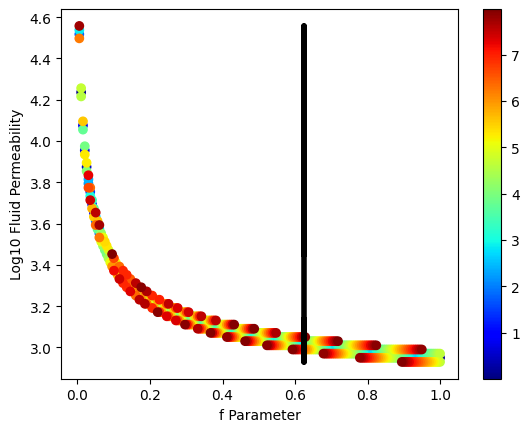

In [ ]:
scatter = plt.scatter(filtered_results[f'f_{idx}'], np.log10(filtered_results[f'Fluid perm_{idx}']),
                      c=filtered_results[f'Diff_{idx}'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')


porosity = data["Porosity,%"][idx]
ar_pore = data['AR thermal'][idx]
f = f_from_e(porosity, ar_pore)

print(porosity,ar_pore, f)

f_list = [f for _ in range(len(filtered_results[f'f_{idx}']))]
plt.plot(f_list,  np.log10(filtered_results[f'Fluid perm_{idx}']), color='black', lw=4)


3.5611613848643877 0.22102335086940447


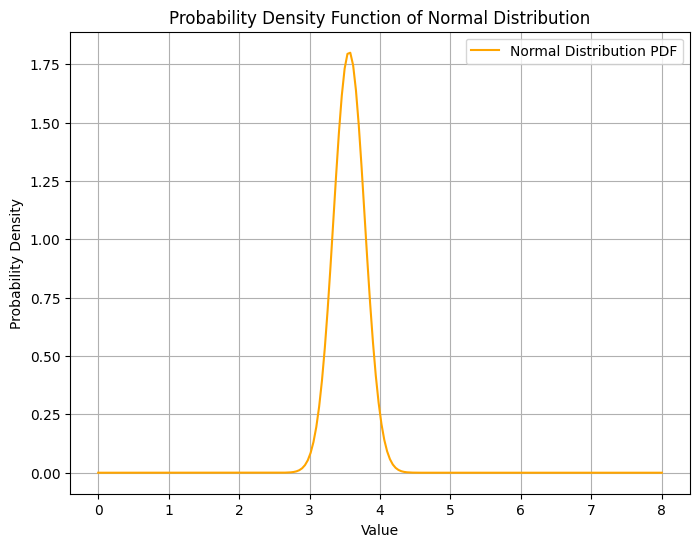

In [ ]:
from scipy.stats import norm

# Parameters of the normal distribution
data = data = np.log10(filtered_results[f'Fluid perm_{idx}'])
mean = np.mean(data)
std_dev = np.std(data)
print(mean, std_dev)

# Generate data points for the PDF
x = np.linspace(0, 8, 200)
pdf = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(8, 6))

plt.plot(x, pdf, label='Normal Distribution PDF', color='orange')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Direct problem with selected parametrs for permeability

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
porosity = data["Porosity,%"]
ar_pore = data['AR thermal']

for i, j in zip(porosity, ar_pore):
  print(f_from_e(i,j))

(4.5249, 0.16200121518795096, -0.7904817277571085, 0.6266627905700239)
(6.4733712859514565, 0.11509156944967604, -0.9389564876263328, 0.6535319026382558)
(15.02428813868614, 0.2720847621533875, -0.5652957797858644, 0.7949449247949966)
(14.192653640237129, 0.27667737532070213, -0.5580263528760461, 0.7998051104973494)
(9.432965948473461, 0.2757788260887629, -0.5594390814009903, 0.814881602137336)
(9.294072678275302, 0.15350318327320867, -0.8138826139089169, 0.7038421780410956)
(8.824132941979359, 0.14047040464126123, -0.8524151665410293, 0.688042552190449)
(7.476560681237662, 0.14846184557568443, -0.8283851448990981, 0.6978642942025601)
(6.812695477572067, 0.1026198185081042, -0.988768757766763, 0.6342792247208193)
(8.326069547301874, 0.15935021304413963, -0.7976473515574755, 0.7105791998980127)
(8.011973979984601, 0.12292768461199721, -0.9103502983972054, 0.6647902228188343)
(17.53453832771655, 0.32946336483118427, -0.48219287040599756, 0.8237546919284073)
(7.992399227956115, 0.14473963

In [ ]:
porosity = data["Porosity,%"]
exp_permeability = data["Permeability"]
ar_pore_initial = data['AR thermal']
ar_pore = data['AR thermal']
mtrx_perm = 2*10**-4
# fluid_comp =
# fluid_perm = 10**2.8
# f = 0.3

import math
calculation_perm =[]

# table = pd.DataFrame()
# table['f mean'] = all_means_f
# table['porosity'] = all_porosity
# table['K i'] = all_means_i


for ar, por, fluid_perm in zip(ar_pore, porosity, all_means_i):

  por = por/100
  conc = [1-por, por]
  alpha_shape = [1, ar]

  # fluid_perm = 1.4097*np.log(por*100)-0.6603

  components = [mtrx_perm, fluid_perm]
  f = f_from_e(por*100, ar)
  print(por, f, components)
  calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

0.045249 0.7810705277902696 [0.0002, 1.2218125796697292]
0.06473371285951457 0.6535319026382558 [0.0002, 2.3918744586751606]
0.1502428813868614 0.7949449247949966 [0.0002, 2.3911453306236097]
0.1419265364023713 0.7998051104973494 [0.0002, 2.5228488268415763]
0.09432965948473461 0.814881602137336 [0.0002, 3.2532228554894855]
0.09294072678275303 0.7038421780410956 [0.0002, 2.892180568791246]
0.0882413294197936 0.688042552190449 [0.0002, 1.5003329913981576]
0.07476560681237662 0.6978642942025601 [0.0002, 0]
0.06812695477572067 0.6342792247208193 [0.0002, 1.1705684812253223]
0.08326069547301873 0.7105791998980127 [0.0002, 1.7856434269479184]
0.08011973979984602 0.6647902228188343 [0.0002, 2.0358222656107534]
0.1753453832771655 0.8237546919284073 [0.0002, 3.5611613852920962]
0.07992399227956115 0.6933441950989695 [0.0002, 2.8098667731025326]
0.09789559467455616 0.6241973988096589 [0.0002, 3.1337999922016238]
0.2358372317110681 0 [0.0002, 4.276966028363398]
0.09160330411903464 0.592835684538

In [ ]:
results = pd.DataFrame()
results['Sample'] = data["Sample"]
results['Porosity'] = data["Porosity,%"]
results['Calculatioin perm'] = np.log10(calculation_perm)
results['Expermental'] = np.log10(exp_permeability)


results['Abs Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']))
results['Relative Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']) / results['Expermental']) * 100

In [ ]:
results

,Sample,Porosity,Calculatioin perm,Expermental,Abs Error,Relative Error
0,113480,4.524900,-1.457830,-0.079490,1.378340,1733.977919
1,113532,6.473371,-1.034441,-0.595674,0.438766,73.658742
2,113536,15.024288,-0.627693,1.263271,1.890964,149.687889
3,113541,14.192654,-0.629701,1.239147,1.868847,150.817277
4,113556,9.432966,-0.701924,1.198024,1.899948,158.590113
5,113566,9.294073,-0.780215,1.898270,2.678485,141.101375
6,113572,8.824133,-1.091379,1.511726,2.603105,172.194241
7,113577,7.476561,-3.843652,0.053109,3.896761,7337.262864
9,113603,6.812695,-1.326248,-0.398691,0.927557,232.650650
10,113619,8.326070,-1.036937,0.388513,1.425450,366.898660


[]

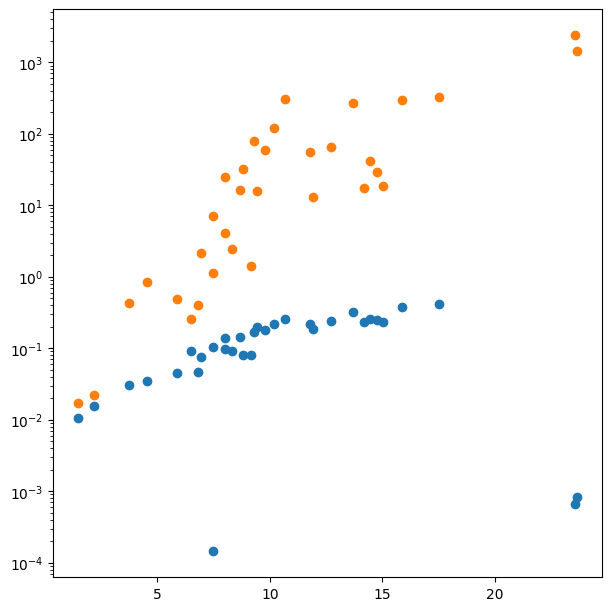

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Porosity'], 10**results['Calculatioin perm'])
ax.scatter(results['Porosity'], 10**results['Expermental'])
ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])

# ax.plot([-2, -2], [-2,4])

plt.plot()

[]

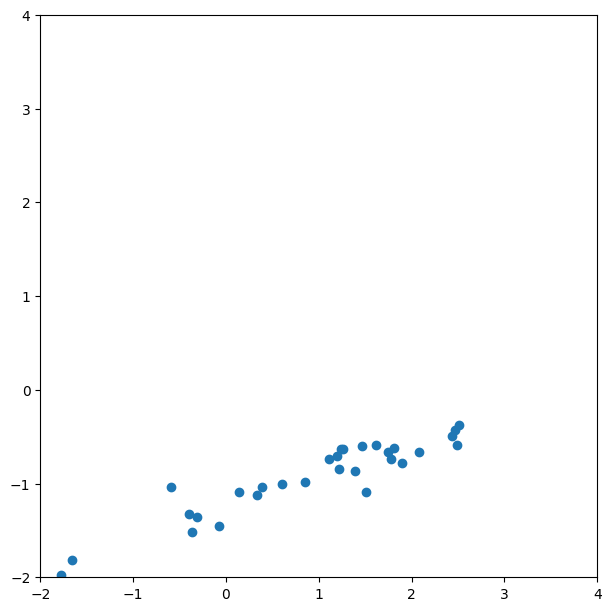

In [ ]:

fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Expermental'], results['Calculatioin perm'])
# ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])

# ax.plot([-2, -2], [-2,4])
ax.set_xlim([-2, 4])
ax.set_ylim([-2, 4])
plt.plot()

[]

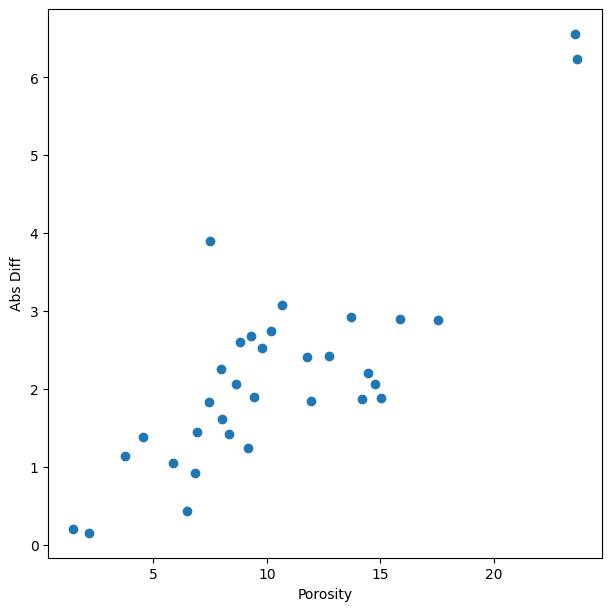

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Porosity'], results['Abs Error'])
# ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])
plt.xlabel('Porosity')
plt.ylabel('Abs Diff')
# plt.ylim(0, 200)
plt.plot()

### Plots for all samples

In [ ]:
path_to_ser = Path('/content/Tver_book_perm_1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='PERM_INVERSE', skiprows=0)

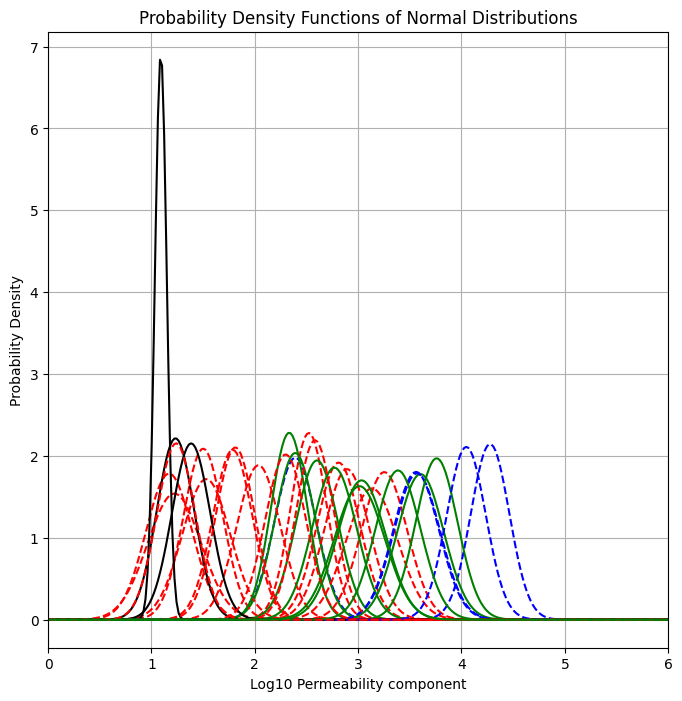

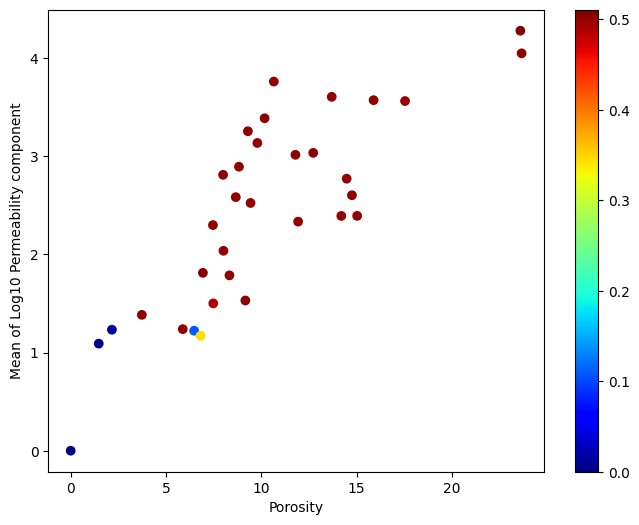

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Initialize an empty array to store all PDFs
all_pdfs = []
all_means_i = []
all_means_f = []
all_porosity = []


# Define the color map for different porosity ranges
colors = ['black', 'red', 'green', 'blue']
linestyle=['solid', 'dashed', 'solid', 'dashed']

for i in range(1, 34):
  if i == 8:
    all_means_i.append(0)
    all_porosity.append(0)
    all_means_f.append(0)
  else:
    # Parameters of the normal distribution
    data = np.log10(df_ues[f'Fluid perm_{i}'])
    mean = np.mean(data)
    std_dev = np.std(data)

    f_param = np.mean(df_ues[f'f_{i}'])

    # Generate data points for the PDF
    x = np.linspace(0, 10, 500)
    pdf = norm.pdf(x, mean, std_dev)

    # Determine the color based on porosity values
    porosity = df_ues[f'Porosity_{i}'][0]

    if porosity < 5:
      color_index, linestyle_index = 0, 0  # Default color is black
      # print(porosity, color_index)
    if porosity > 5 and porosity < 10:
        color_index, linestyle_index = 1, 1  # Red
        # print(porosity, color_index)
    if porosity > 10 and porosity < 15:
        color_index, linestyle_index = 2, 2  # Green
        # print(porosity, color_index)
    if porosity > 15:
      color_index, linestyle_index = 3, 3  # Green

    # Append the PDF and color to the array
    all_pdfs.append((pdf, colors[color_index], linestyle[linestyle_index] ))
    all_means_i.append(mean)
    all_porosity.append(porosity)
    all_means_f.append(f_param)

# Plot all PDFs on the same plot with different colors
plt.figure(figsize=(8, 8))

for pdf, color, linestyle in all_pdfs:
    plt.plot(x, pdf, color=color, linestyle=linestyle)

plt.xlabel('Log10 Permeability component')
plt.ylabel('Probability Density')
plt.title('Probability Density Functions of Normal Distributions')
plt.xlim(0, 6)
plt.grid(True)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_porosity, all_means_i,
                      c=all_means_f, cmap='jet', marker='o')
plt.xlabel('Porosity')
plt.ylabel('Mean of Log10 Permeability component')
plt.colorbar(scatter)  # Add color bar to the plot
# plt.xlim(0, 25)
# plt.ylim(0, 1)


plt.show()

In [ ]:
table = pd.DataFrame()
table['f mean'] = all_means_f
table['porosity'] = all_porosity
table['K i'] = all_means_i

In [ ]:
table

,f mean,porosity,K i
0,0.108129,6.473371,1.221813
1,0.502164,15.024288,2.391874
2,0.502328,14.192654,2.391145
3,0.501697,9.432966,2.522849
4,0.502426,9.294073,3.253223
5,0.502525,8.824133,2.892181
6,0.487922,7.476561,1.500333
7,0.000000,0.000000,0.000000
8,0.343650,6.812696,1.170568
9,0.504391,8.326069,1.785643


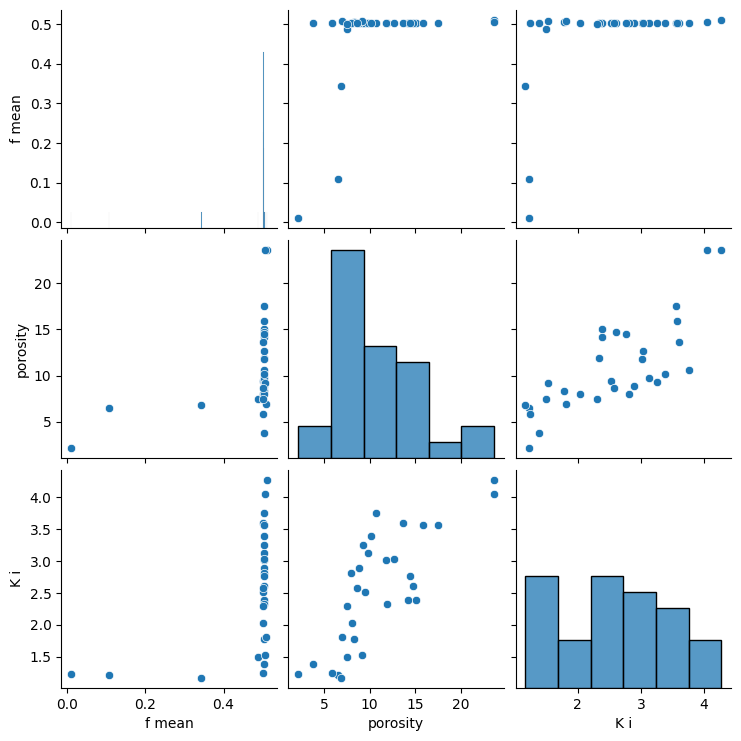

In [ ]:
import seaborn as sns
sns.pairplot(table)

### Input data

In [12]:
path_to_ser = Path('/content/f model.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, skiprows=0)

In [13]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability', 'Density (air)',
       'Density (water)', 'Density (oil)', 'Vp air', 'Vs air', 'Vp oil', 'Vs oil', 'Vp water',
       'Vs water', 'Unnamed: 15', 'AR thermal', 'AO electrical', 'AR elastic', 'Unnamed: 19',
       'TC air', 'TC oil', 'TC 0,6', 'TC 6', 'TC 60', 'TC 180', 'Unnamed: 26', 'Скважина', 'R 0.6',
       'R 6', 'R 60', 'R 180', 'Unnamed: 32', 'Unnamed: 33', 'УЭС, Ом*м', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Провод-ть, См/м', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41'],
      dtype='object')

In [14]:
df_ues_ar.dropna(subset=['Porosity,%'], inplace=True)

In [15]:
idx = 5
porosity = df_ues_ar["Porosity,%"][idx]/100

In [16]:
porosity

0.092940726782753

In [17]:
air_tc_exp = df_ues_ar["TC air"][idx]
water_tc_exp = df_ues_ar["TC 6"][idx]
oil_tc_exp = df_ues_ar["TC oil"][idx]

In [18]:
exp_6 = 1/ df_ues_ar["R 6"][idx]
exp_60 = 1/ df_ues_ar["R 60"][idx]
exp_180 = 1/ df_ues_ar["R 180"][idx]

In [19]:
Vp_exp_air, Vs_exp_air = df_ues_ar["Vp air"][idx], df_ues_ar["Vs air"][idx]
Vp_exp_water, Vs_exp_water = df_ues_ar["Vp water"][idx], df_ues_ar["Vs water"][idx]

density_air, density_water = df_ues_ar["Density (air)"][idx], df_ues_ar["Density (water)"][idx]
p_air, p_water = density_air, density_water

### Thermal conductivity

In [93]:
def table_calculation(fluid_list, lam_matrix):

  for fluid in fluid_list:

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='air':
      lam_fluid = 0.025
    elif fluid == 'water':
      lam_fluid = 0.60
    elif fluid == 'oil':
      lam_fluid = 0.12

    N, n = 100, 50 # Amount of nodes

    for ar_inclusion in np.logspace(-2, 0, N, base=10):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [globals()[f"lam_mtrx_{fluid}"], lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                             [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

    globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                             [globals()[f"lam_mtrx_{fluid}"], lam_fluid])



    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
]


    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [97]:
# fluid_list = ['air', 'water', 'oil']
# fluid_list = ['air']
# fluid_list = ['water']
fluid_list = ['oil']

lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)

  for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

    number = table_calculation(fluid_list, lam_matrix)

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

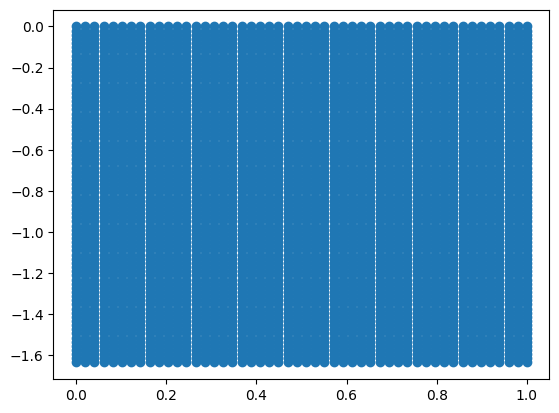

In [54]:
plt.scatter(result_oil["f"], np.log10(result_oil["AR inclusion"]))

In [95]:
result_water[:5]

,"Porosity,%",AR inclusion,f,TC_water,e_water,TC_exp_water,TC_HSup_water,TC_HSlo_water,Diff TC water
900,0.092941,0.023101,0.000000,2.531235,0.960464,2.679425,2.662293,2.500932,5.53
901,0.092941,0.023101,0.020408,2.532601,0.960464,2.679425,2.662293,2.500932,5.48
902,0.092941,0.023101,0.040816,2.533957,0.960464,2.679425,2.662293,2.500932,5.43
903,0.092941,0.023101,0.061224,2.535305,0.960464,2.679425,2.662293,2.500932,5.38
904,0.092941,0.023101,0.081633,2.536642,0.960464,2.679425,2.662293,2.500932,5.33


(0.0, 10.0)

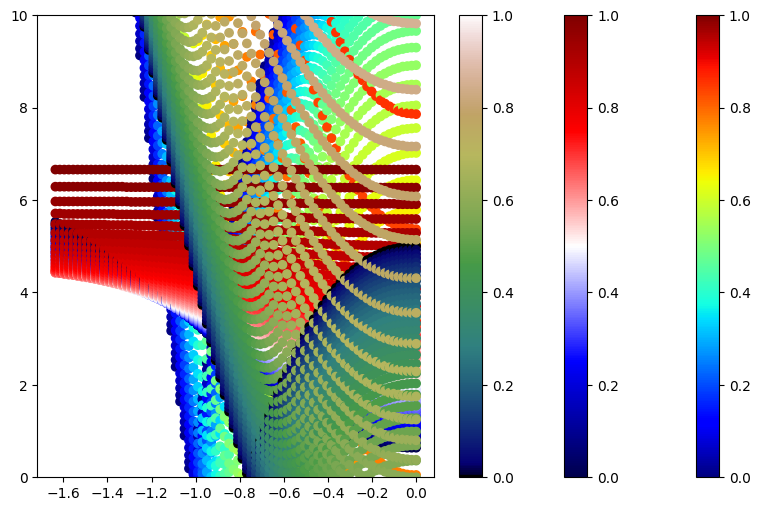

In [98]:
plt.figure(figsize=(10, 6))

scatter_1 = plt.scatter(np.log10(result_air['AR inclusion']),result_air['Diff TC air'],
                      c=result_air['f'], cmap='jet', marker='o')

scatter_2 = plt.scatter(np.log10(result_water['AR inclusion']),result_water['Diff TC water'],
                      c=result_water['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_oil['AR inclusion']),result_oil['Diff TC oil'],
                      c=result_oil['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)

In [99]:
error = 5

In [100]:
selected_row_air = result_air[(abs(result_air['Diff TC air']) <= error)]
selected_row_air[:5]

,"Porosity,%",AR inclusion,f,TC_air,e_air,TC_exp_air,TC_HSup_air,TC_HSlo_air,Diff TC air
2100,0.092941,0.070548,0.000000,2.137547,0.314509,2.244775,2.561757,0.598692,4.78
2101,0.092941,0.070548,0.020408,2.134204,0.314509,2.244775,2.561757,0.598692,4.93
2150,0.092941,0.073907,0.000000,2.155841,0.300214,2.244775,2.561757,0.598692,3.96
2151,0.092941,0.073907,0.020408,2.152510,0.300214,2.244775,2.561757,0.598692,4.11
2152,0.092941,0.073907,0.040816,2.149058,0.300214,2.244775,2.561757,0.598692,4.26


In [101]:
selected_row_water = result_water[result_water['Diff TC water'] <= error]
selected_row_water[:5]

,"Porosity,%",AR inclusion,f,TC_water,e_water,TC_exp_water,TC_HSup_water,TC_HSlo_water,Diff TC water
911,0.092941,0.023101,0.224490,2.545598,0.960464,2.679425,2.662293,2.500932,4.99
912,0.092941,0.023101,0.244898,2.546801,0.960464,2.679425,2.662293,2.500932,4.95
913,0.092941,0.023101,0.265306,2.547979,0.960464,2.679425,2.662293,2.500932,4.91
914,0.092941,0.023101,0.285714,2.549130,0.960464,2.679425,2.662293,2.500932,4.86
915,0.092941,0.023101,0.306122,2.550252,0.960464,2.679425,2.662293,2.500932,4.82


In [102]:
selected_row_oil = result_oil[result_oil['Diff TC oil'] <= error]
selected_row_oil[:5]

,"Porosity,%",AR inclusion,f,TC_oil,e_oil,TC_exp_oil,TC_HSup_oil,TC_HSlo_oil,Diff TC oil
2450,0.092941,0.097701,0.000000,2.344393,0.227101,2.4567,2.579518,1.603273,4.57
2451,0.092941,0.097701,0.020408,2.342662,0.227101,2.4567,2.579518,1.603273,4.64
2452,0.092941,0.097701,0.040816,2.340871,0.227101,2.4567,2.579518,1.603273,4.71
2453,0.092941,0.097701,0.061224,2.339016,0.227101,2.4567,2.579518,1.603273,4.79
2454,0.092941,0.097701,0.081633,2.337095,0.227101,2.4567,2.579518,1.603273,4.87


In [103]:
# Merge selected_row_air and selected_row_water first
merged_data_tc = pd.merge(selected_row_air,
                       selected_row_water,
                       on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

# Then merge the result with selected_row_oil
merged_data_tc = pd.merge(merged_data_tc,
                       selected_row_oil,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

merged_data_tc['total diff'] = np.sqrt(merged_data_tc["Diff TC air"]**2 + \
                                    merged_data_tc["Diff TC water"]**2 +\
                                    merged_data_tc["Diff TC oil"]**2 )

In [104]:
merged_data_tc[:5]

,"Porosity,%_air",AR inclusion,f,TC_air,e_air,TC_exp_air,TC_HSup_air,TC_HSlo_air,Diff TC air,"Porosity,%_water",TC_water,e_water,TC_exp_water,TC_HSup_water,TC_HSlo_water,Diff TC water,"Porosity,%",TC_oil,e_oil,TC_exp_oil,TC_HSup_oil,TC_HSlo_oil,Diff TC oil,total diff
0,0.092941,0.097701,0.000000,2.256149,0.227101,2.244775,2.561757,0.598692,0.51,0.092941,2.588664,0.227101,2.679425,2.662293,2.500932,3.39,0.092941,2.344393,0.227101,2.4567,2.579518,1.603273,4.57,5.712889
1,0.092941,0.097701,0.020408,2.252940,0.227101,2.244775,2.561757,0.598692,0.36,0.092941,2.588717,0.227101,2.679425,2.662293,2.500932,3.39,0.092941,2.342662,0.227101,2.4567,2.579518,1.603273,4.64,5.757717
2,0.092941,0.097701,0.040816,2.249610,0.227101,2.244775,2.561757,0.598692,0.22,0.092941,2.588758,0.227101,2.679425,2.662293,2.500932,3.38,0.092941,2.340871,0.227101,2.4567,2.579518,1.603273,4.71,5.801457
3,0.092941,0.097701,0.061224,2.246154,0.227101,2.244775,2.561757,0.598692,0.06,0.092941,2.588788,0.227101,2.679425,2.662293,2.500932,3.38,0.092941,2.339016,0.227101,2.4567,2.579518,1.603273,4.79,5.862772
4,0.092941,0.097701,0.081633,2.242562,0.227101,2.244775,2.561757,0.598692,0.10,0.092941,2.588804,0.227101,2.679425,2.662293,2.500932,3.38,0.092941,2.337095,0.227101,2.4567,2.579518,1.603273,4.87,5.928853


(0.0, 1.0)

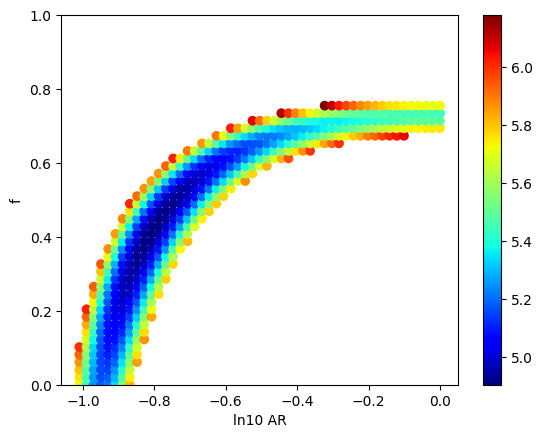

In [105]:
scatter = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
                      c=merged_data_tc["total diff"], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(array([1.33460765, 2.25090543, 1.59356137, 1.09557344, 0.83661972,
        0.67726358, 0.577666  , 0.53782696, 0.49798793, 0.49798793]),
 array([-1.01010101, -0.90909091, -0.80808081, -0.70707071, -0.60606061,
        -0.50505051, -0.4040404 , -0.3030303 , -0.2020202 , -0.1010101 ,
         0.        ]),
 <BarContainer object of 10 artists>)

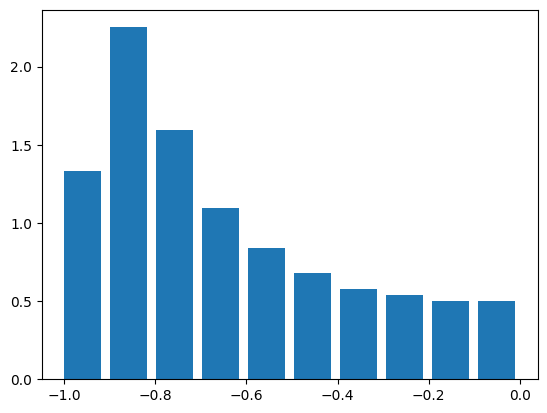

In [115]:
plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

(array([0.87933003, 0.95926913, 1.01256186, 0.79939094, 1.11914732,
        1.19908641, 1.01256186, 1.49219642, 2.1850019 , 2.58469737]),
 array([0.        , 0.0755102 , 0.15102041, 0.22653061, 0.30204082,
        0.37755102, 0.45306122, 0.52857143, 0.60408163, 0.67959184,
        0.75510204]),
 <BarContainer object of 10 artists>)

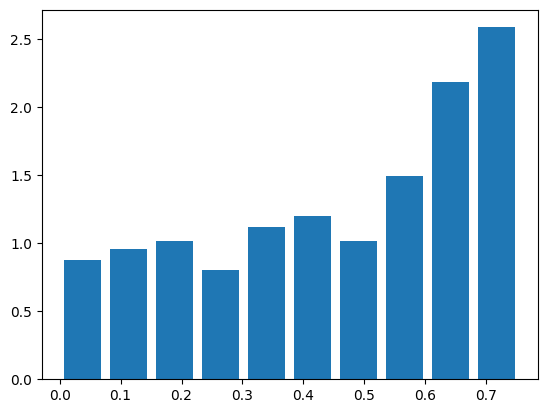

In [116]:
plt.hist(merged_data_tc["f"], bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

### Electrical conductivity

In [ ]:
def table_calculation(fluid_list, lam_matrix):

  for fluid in fluid_list:

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='6':
      lam_fluid = 1.060
    elif fluid == '60':
      lam_fluid = 8.42
    elif fluid == '180':
      lam_fluid = 18.87

    N, n = 200, 50 # Amount of nodes

    for ar_inclusion in np.logspace(-2, 0, N):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [globals()[f"lam_mtrx_{fluid}"], lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(1/lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [1/globals()[f'exp_{fluid}']]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    # globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = np.log10(abs((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp)))

    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [ ]:
# fluid_list = ['6', '60', '180']
fluid_list = ['6']

lam_6, lam_60, lam_180 = 1.060, 8.42, 18.87
lam_mtrx_6, lam_mtrx_60, lam_mtrx_180 = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

error_6, error_60, error_180 = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)

  for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

    number = table_calculation(fluid_list, lam_matrix)

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

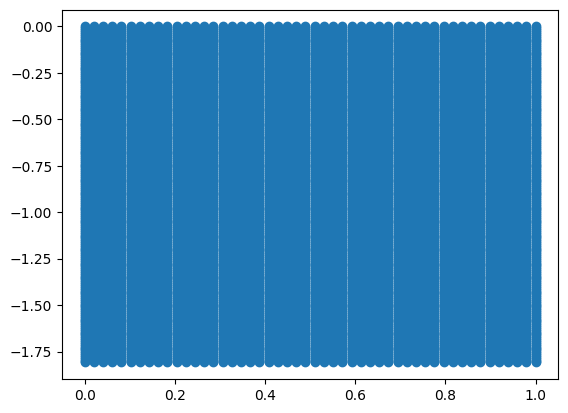

In [ ]:
plt.scatter(result_6["f"], np.log10(result_6["AR inclusion"]))

In [ ]:
result_60[:10]

,"Porosity,%",AR inclusion,f,TC_60,TC_exp_60,e_60,Diff TC 60
2800,0.150243,0.036544,0.000000,13.762655,5.804218,0.981502,137.11
2801,0.150243,0.036544,0.020408,3.120934,5.804218,0.981502,46.23
2802,0.150243,0.036544,0.040816,2.355251,5.804218,0.981502,59.42
2803,0.150243,0.036544,0.061224,2.067013,5.804218,0.981502,64.39
2804,0.150243,0.036544,0.081633,1.911476,5.804218,0.981502,67.07
2805,0.150243,0.036544,0.102041,1.811531,5.804218,0.981502,68.79
2806,0.150243,0.036544,0.122449,1.740198,5.804218,0.981502,70.02
2807,0.150243,0.036544,0.142857,1.685579,5.804218,0.981502,70.96
2808,0.150243,0.036544,0.163265,1.641612,5.804218,0.981502,71.72
2809,0.150243,0.036544,0.183673,1.604881,5.804218,0.981502,72.35


(0.0, 10.0)

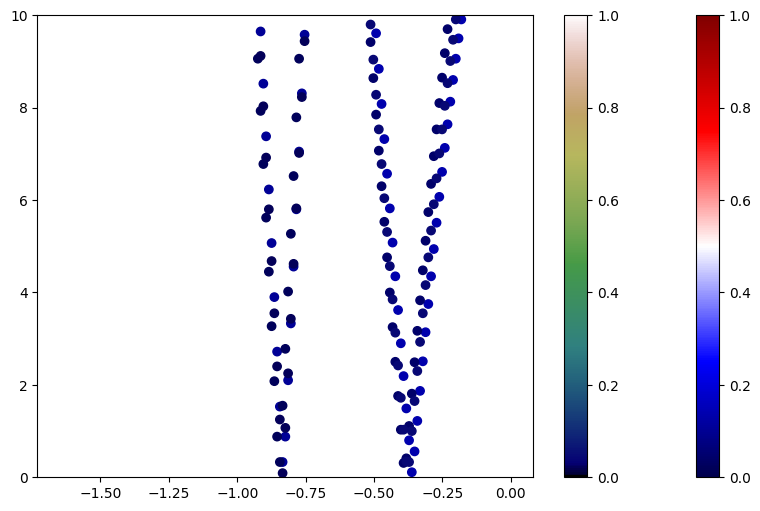

In [ ]:
plt.figure(figsize=(10, 6))

scatter1 = plt.scatter(np.log10(result_60['AR inclusion']),result_60['Diff TC 60'],
                      c=result_60['f'], cmap='jet', marker='o')

scatter_2 = plt.scatter(np.log10(result_6['AR inclusion']),result_6['Diff TC 6'],
                      c=result_6['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_180['AR inclusion']),result_180['Diff TC 180'],
                      c=result_180['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)


In [ ]:
error = 5

In [ ]:
selected_row_6 = result_6[(abs(result_6['Diff TC 6']) <= error)]
selected_row_6[:5]

,"Porosity,%",AR inclusion,f,TC_6,TC_exp_6,e_6,Diff TC 6
5551,0.092941,0.130490,0.020408,79.202471,82.893619,0.170035,4.45
5601,0.092941,0.133545,0.020408,80.180682,82.893619,0.166146,3.27
5651,0.092941,0.136672,0.020408,81.167542,82.893619,0.162345,2.08
5701,0.092941,0.139871,0.020408,82.162849,82.893619,0.158631,0.88
5751,0.092941,0.143146,0.020408,83.166388,82.893619,0.155002,0.33


In [ ]:
selected_row_60 = result_60[result_60['Diff TC 60'] <= error]
selected_row_60[:5]

,"Porosity,%",AR inclusion,f,TC_60,TC_exp_60,e_60,Diff TC 60
5651,0.092941,0.136672,0.020408,10.243693,10.65925,0.162345,3.90
5701,0.092941,0.139871,0.020408,10.369514,10.65925,0.158631,2.72
5751,0.092941,0.143146,0.020408,10.496381,10.65925,0.155002,1.53
5801,0.092941,0.146497,0.020408,10.624264,10.65925,0.151457,0.33
5851,0.092941,0.149927,0.020408,10.753134,10.65925,0.147992,0.88


In [ ]:
selected_row_180= result_180[result_180['Diff TC 180'] <= error]
selected_row_180[:5]

,"Porosity,%",AR inclusion,f,TC_180,TC_exp_180,e_180,Diff TC 180
5601,0.092941,0.133545,0.020408,4.276662,4.486661,0.166146,4.68
5651,0.092941,0.136672,0.020408,4.327516,4.486661,0.162345,3.55
5701,0.092941,0.139871,0.020408,4.378770,4.486661,0.158631,2.40
5751,0.092941,0.143146,0.020408,4.430411,4.486661,0.155002,1.25
5801,0.092941,0.146497,0.020408,4.482426,4.486661,0.151457,0.09


In [ ]:

# Merge selected_row_air and selected_row_water first
merged_data = pd.merge(selected_row_6,
                       selected_row_60,
                       on=["AR inclusion", "f"], suffixes=('_6', '60'), how='inner')

# Then merge the result with selected_row_oil
merged_data = pd.merge(merged_data,
                       selected_row_180,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_180'), how='inner')

merged_data['total diff'] = np.sqrt(merged_data["Diff TC 6"]**2 + \
                                    merged_data["Diff TC 60"]**2 +\
                                    merged_data["Diff TC 180"]**2 )

In [ ]:
merged_data[:5]

,"Porosity,%_6",AR inclusion,f,TC_6,TC_exp_6,e_6,Diff TC 6,"Porosity,%60",TC_60,TC_exp_60,e_60,Diff TC 60,"Porosity,%",TC_180,TC_exp_180,e_180,Diff TC 180,total diff
0,0.092941,0.136672,0.020408,81.167542,82.893619,0.162345,2.08,0.092941,10.243693,10.65925,0.162345,3.90,0.092941,4.327516,4.486661,0.162345,3.55,5.669118
1,0.092941,0.139871,0.020408,82.162849,82.893619,0.158631,0.88,0.092941,10.369514,10.65925,0.158631,2.72,0.092941,4.378770,4.486661,0.158631,2.40,3.732667
2,0.092941,0.143146,0.020408,83.166388,82.893619,0.155002,0.33,0.092941,10.496381,10.65925,0.155002,1.53,0.092941,4.430411,4.486661,0.155002,1.25,2.003073
3,0.092941,0.146497,0.020408,84.177933,82.893619,0.151457,1.55,0.092941,10.624264,10.65925,0.151457,0.33,0.092941,4.482426,4.486661,0.151457,0.09,1.587293
4,0.092941,0.149927,0.020408,85.197248,82.893619,0.147992,2.78,0.092941,10.753134,10.65925,0.147992,0.88,0.092941,4.534802,4.486661,0.147992,1.07,3.106075


(0.0, 1.0)

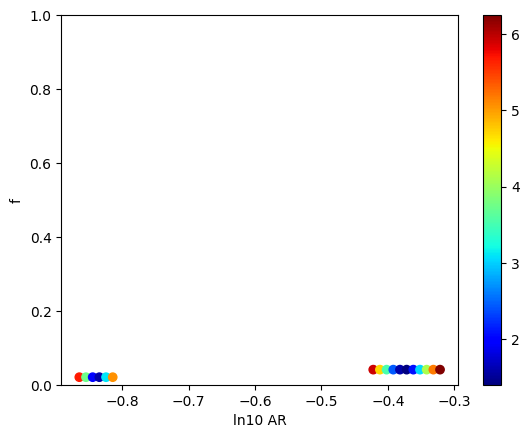

In [ ]:
scatter = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
                      c= merged_data["total diff"], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(0.0, 1.0)

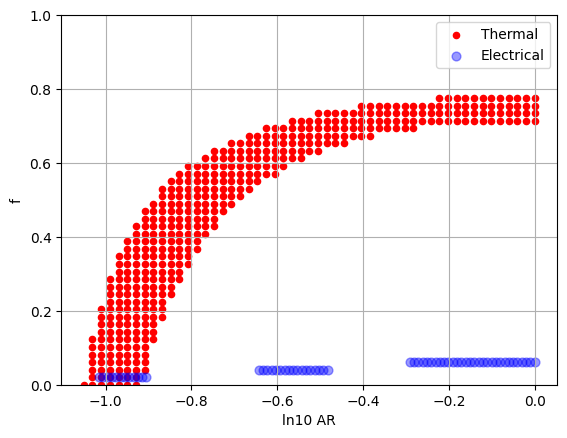

In [ ]:
# scatter1 = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
#                       c= merged_data_tc["total diff"], cmap='seismic', marker='o')

# scatter2 = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
#                       c= merged_data["total diff"], cmap='hsv', marker='o')

# plt.colorbar(scatter1)  # Add color bar to the plot
# plt.colorbar(scatter2)  # Add color bar to the plot


plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')

plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', alpha=0.4, s=40, label='Electrical')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')
plt.grid()
plt.legend()

plt.ylim(0, 1)

### Elastic

In [119]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [120]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [121]:
def HS_borders(K, μ, f):


  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 +
                        f[0]*(K[0]+4/3*μ[0])**-1))

  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 +
                        f[1]*(K[1]+4/3*μ[1])**-1))

  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 +
                          2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))

  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 +
                          2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [122]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [123]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [124]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por, f):

  K, Mu = 0, 0

  x0, x1 = K_matrix*(1-f)+K_fluid*f, Mu_matrix*(1-f) + Mu_fluid*f ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  # while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
  #   # print(x0, x1, K_eff, Mu_eff)
  #   x0, x1 = K_eff, Mu_eff
  #   K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [125]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


In [126]:
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

In [127]:
# N, n = 100, 6

# for f in np.linspace(0, 1, n):

#   Vp_array, Vs_array = [], []

#   for porosity in np.linspace(0, 0.1, N):

#     AR_mtrx, AR_inclusion = 1, 0.01

#     K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_air_mtrx, Mu_air_mtrx, K_air, Mu_air, porosity, f)
#     density_mtrx, density_fluid = 2.71, p_air
#     Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

#     Vp_array.append(Vp)
#     Vs_array.append(Vs)

#   plt.plot(np.linspace(0, 1, N),  Vp_array, label=f"{np.round(f, 1)}")
#   plt.plot(np.linspace(0, 1, N),  Vs_array, label=f"{np.round(f, 1)}")
#   plt.legend()
# plt.xlim(0,1)
# # plt.ylim(0,3)
# plt.grid()
# plt.title('Porosity - Elastic with dependecence from f')


In [138]:
fluid_list = ['air', 'water']
eps = 10**-8

for fluid in fluid_list:

    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []
    AR_list = []
    K_mtrx_var, mu_mtrx_var = [], []
    f_list = []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)

    error_mtrx = 0.05
### Matrix range
    globals()[f"K_{fluid}_matix_range"] = [globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * error_mtrx ,
                                      globals()[f"K_{fluid}_mtrx"],
                                      globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * error_mtrx ]

    globals()[f"Mu_{fluid}_matix_range"] = [globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ,
                                      globals()[f"Mu_{fluid}_mtrx"],
                                      globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ]

    N, n = 100, 50

    for ar_inclusion in np.logspace(-2, 0, num=N, base=10):

      for f in np.linspace(0, 1, n):

        AR_inclusion = ar_inclusion
        AR_mtrx = 1.00001

        for k, mu in zip(globals()[f"K_{fluid}_matix_range"], globals()[f"Mu_{fluid}_matix_range"]):

          AR_list.append(ar_inclusion)
          f_list.append(f)

          K_matrix, Mu_matrix = k, mu
          K_mtrx_var.append(K_matrix)
          mu_mtrx_var.append(Mu_matrix)

          K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, k, mu, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"] , porosity, f)
          density_mtrx, density_fluid = 2.71, globals()[f"density_{fluid}"]
          Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

          Vp_fluid_list.append(Vp)
          Vs_fluid_list.append(Vs)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = AR_list
    globals()[f'result_{fluid}'][f'f'] = f_list

    globals()[f'result_{fluid}'][f'K matrx {fluid}'] = K_mtrx_var
    globals()[f'result_{fluid}'][f'Mu matrx {fluid}'] = mu_mtrx_var

    globals()[f'result_{fluid}'][f'Vp {fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs {fluid}'] = Vs_fluid_list

    globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'] = [globals()[f'Vp_exp_{fluid}']]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'] = [globals()[f'Vs_exp_{fluid}']]*len(Vs_fluid_list)

    # HS_borders

    globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], _, _, _, _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])

    _, _, _, globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'], _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])


    globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'])


    globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'])


### Selection
    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] >= globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] <= globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'])
]

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] >= globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] <= globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'])
]


    Vp_exp, Vs_exp = globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]

### Relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

    globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'result_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff'] = globals()[f'result_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

# ### Sort values
#     globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'].sort_values(by=f'Diff')

<ipython-input-120-a336f510f645>:5: RuntimeWarning: invalid value encountered in sqrt
  Vs = np.sqrt(Mu/density)


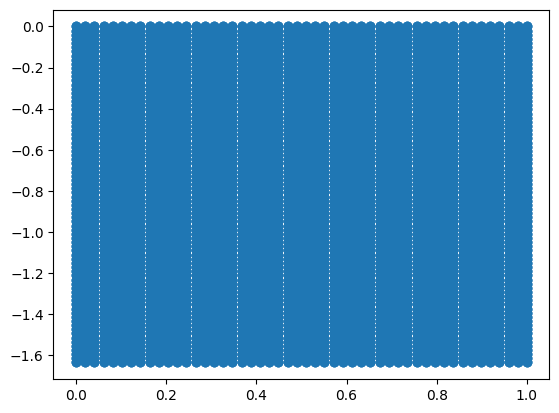

In [ ]:
plt.scatter(result_air["f"], np.log10(result_air["AR inclusion"]))

In [139]:
result_water[:10]

,"Porosity,%",AR inclusion,f,K matrx water,Mu matrx water,Vp water,Vs water,Vp_exp_water,Vs_exp_water,K_HSup_water,K_HSlo_water,Mu_HSup_water,Mu_HSlo_water,Vp_HSup_water,Vs_HSup_water,Vp_HSlo_water,Vs_HSlo_water,e_water,Diff Vp water,Diff Vs water,Diff
2700,0.092941,0.023101,0.000000,60.484187,27.193156,3.950753,2.179449,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.18,-19.98,27.70
2701,0.092941,0.023101,0.000000,63.667566,28.624375,4.026098,2.232845,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.64,-18.02,25.22
2702,0.092941,0.023101,0.000000,66.850944,30.055594,4.099426,2.284828,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.14,-16.11,22.80
2703,0.092941,0.023101,0.020408,60.484187,27.193156,3.946978,2.174822,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.26,-20.15,27.87
2704,0.092941,0.023101,0.020408,63.667566,28.624375,4.022040,2.228099,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.72,-18.19,25.39
2705,0.092941,0.023101,0.020408,66.850944,30.055594,4.095085,2.279963,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.23,-16.29,23.00
2706,0.092941,0.023101,0.040816,60.484187,27.193156,3.943070,2.170025,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.34,-20.32,28.05
2707,0.092941,0.023101,0.040816,63.667566,28.624375,4.017843,2.223177,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.81,-18.37,25.59
2708,0.092941,0.023101,0.040816,66.850944,30.055594,4.090599,2.274919,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.32,-16.47,23.19
2709,0.092941,0.023101,0.061224,60.484187,27.193156,3.939023,2.165047,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.42,-20.50,28.24


In [140]:
result_air["AR inclusion"].min(), result_air["AR inclusion"].max()

(0.023101297000831605, 1.0)

In [141]:
result_water[:10]

,"Porosity,%",AR inclusion,f,K matrx water,Mu matrx water,Vp water,Vs water,Vp_exp_water,Vs_exp_water,K_HSup_water,K_HSlo_water,Mu_HSup_water,Mu_HSlo_water,Vp_HSup_water,Vs_HSup_water,Vp_HSlo_water,Vs_HSlo_water,e_water,Diff Vp water,Diff Vs water,Diff
2700,0.092941,0.023101,0.000000,60.484187,27.193156,3.950753,2.179449,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.18,-19.98,27.70
2701,0.092941,0.023101,0.000000,63.667566,28.624375,4.026098,2.232845,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.64,-18.02,25.22
2702,0.092941,0.023101,0.000000,66.850944,30.055594,4.099426,2.284828,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.14,-16.11,22.80
2703,0.092941,0.023101,0.020408,60.484187,27.193156,3.946978,2.174822,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.26,-20.15,27.87
2704,0.092941,0.023101,0.020408,63.667566,28.624375,4.022040,2.228099,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.72,-18.19,25.39
2705,0.092941,0.023101,0.020408,66.850944,30.055594,4.095085,2.279963,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.23,-16.29,23.00
2706,0.092941,0.023101,0.040816,60.484187,27.193156,3.943070,2.170025,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.34,-20.32,28.05
2707,0.092941,0.023101,0.040816,63.667566,28.624375,4.017843,2.223177,4.8885,2.7235,51.064921,18.000571,23.950380,2.539886e-19,5.699783,3.061813,2.654395,3.153041e-10,0.960464,-17.81,-18.37,25.59
2708,0.092941,0.023101,0.040816,66.850944,30.055594,4.090599,2.274919,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.960464,-16.32,-16.47,23.19
2709,0.092941,0.023101,0.061224,60.484187,27.193156,3.939023,2.165047,4.8885,2.7235,48.562523,17.760846,22.752861,2.539886e-19,5.557252,2.984286,2.636661,3.153041e-10,0.960464,-19.42,-20.50,28.24


In [142]:
calc_error = 5 # достуимая ошибка между эксериментальными и расчетными данными

In [143]:
selected_row_air = result_air[(abs(result_air['Diff Vp air']) <= calc_error ) &\
                             (abs(result_air['Diff Vs air']) <= calc_error)]
selected_row_air[:5]

,"Porosity,%",AR inclusion,f,K matrx air,Mu matrx air,Vp air,Vs air,Vp_exp_air,Vs_exp_air,K_HSup_air,K_HSlo_air,Mu_HSup_air,Mu_HSlo_air,Vp_HSup_air,Vs_HSup_air,Vp_HSlo_air,Vs_HSlo_air,e_air,Diff Vp air,Diff Vs air,Diff
3902,0.092941,0.033516,0.000000,56.60942,28.594145,3.575381,2.282717,3.756667,2.222333,45.121355,0.000024,23.883563,0.00002,5.470852,3.047577,0.004427,0.002787,0.662011,-4.83,2.72,5.54
4052,0.092941,0.035112,0.000000,56.60942,28.594145,3.624576,2.307895,3.756667,2.222333,45.121355,0.000024,23.883563,0.00002,5.470852,3.047577,0.004427,0.002787,0.631921,-3.52,3.85,5.22
4055,0.092941,0.035112,0.020408,56.60942,28.594145,3.612015,2.301900,3.756667,2.222333,45.121355,0.000024,23.883563,0.00002,5.470852,3.047577,0.004427,0.002787,0.631921,-3.85,3.58,5.26
4058,0.092941,0.035112,0.040816,56.60942,28.594145,3.599072,2.295700,3.756667,2.222333,45.121355,0.000024,23.883563,0.00002,5.470852,3.047577,0.004427,0.002787,0.631921,-4.20,3.30,5.34
4061,0.092941,0.035112,0.061224,56.60942,28.594145,3.585727,2.289284,3.756667,2.222333,45.121355,0.000024,23.883563,0.00002,5.470852,3.047577,0.004427,0.002787,0.631921,-4.55,3.01,5.46


In [144]:
selected_row_water = result_water[(abs(result_water['Diff Vp water']) <= calc_error ) &\
                               (abs(result_water['Diff Vs water'])  <= calc_error )]
selected_row_water[:5]

,"Porosity,%",AR inclusion,f,K matrx water,Mu matrx water,Vp water,Vs water,Vp_exp_water,Vs_exp_water,K_HSup_water,K_HSlo_water,Mu_HSup_water,Mu_HSlo_water,Vp_HSup_water,Vs_HSup_water,Vp_HSlo_water,Vs_HSlo_water,e_water,Diff Vp water,Diff Vs water,Diff
5402,0.092941,0.053367,0.000000,66.850944,30.055594,4.675265,2.665315,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.36,-2.14,4.86
5405,0.092941,0.053367,0.020408,66.850944,30.055594,4.668427,2.661046,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.50,-2.29,5.05
5408,0.092941,0.053367,0.040816,66.850944,30.055594,4.661390,2.656624,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.65,-2.46,5.26
5411,0.092941,0.053367,0.061224,66.850944,30.055594,4.654145,2.652037,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.79,-2.62,5.46
5414,0.092941,0.053367,0.081633,66.850944,30.055594,4.646682,2.647279,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.95,-2.80,5.69


In [145]:
### Объеденение результатов инверсии для воздуха и воды. Объединяются по столбцу "AR inclusion"
merged_data_elastic = pd.merge(selected_row_air,
                       selected_row_water, on="AR inclusion", suffixes=('_air', '_water'), how='inner')

# merged_data will contain the rows where the "AR inclusion" values are equal in both DataFrames

merged_data_elastic['Diff air+water'] = np.sqrt(merged_data_elastic['Diff_air']*0.3 +merged_data_elastic['Diff_water']*0.7)
merged_data_elastic.sort_values(by=f'Diff air+water')

merged_data_elastic[:5]

,"Porosity,%_air",AR inclusion,f_air,K matrx air,Mu matrx air,Vp air,Vs air,Vp_exp_air,Vs_exp_air,K_HSup_air,K_HSlo_air,Mu_HSup_air,Mu_HSlo_air,Vp_HSup_air,Vs_HSup_air,Vp_HSlo_air,Vs_HSlo_air,e_air,Diff Vp air,Diff Vs air,Diff_air,"Porosity,%_water",f_water,K matrx water,Mu matrx water,Vp water,Vs water,Vp_exp_water,Vs_exp_water,K_HSup_water,K_HSlo_water,Mu_HSup_water,Mu_HSlo_water,Vp_HSup_water,Vs_HSup_water,Vp_HSlo_water,Vs_HSlo_water,e_water,Diff Vp water,Diff Vs water,Diff_water,Diff air+water
0,0.092941,0.053367,0.204082,51.218047,25.870893,3.722205,2.332896,3.756667,2.222333,40.824084,0.000024,21.608938,0.00002,5.203818,2.898824,0.004427,0.002787,0.415762,-0.92,4.98,5.06,0.092941,0.000000,66.850944,30.055594,4.675265,2.665315,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.36,-2.14,4.86,2.218107
1,0.092941,0.053367,0.204082,51.218047,25.870893,3.722205,2.332896,3.756667,2.222333,40.824084,0.000024,21.608938,0.00002,5.203818,2.898824,0.004427,0.002787,0.415762,-0.92,4.98,5.06,0.092941,0.020408,66.850944,30.055594,4.668427,2.661046,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.50,-2.29,5.05,2.247888
2,0.092941,0.053367,0.204082,51.218047,25.870893,3.722205,2.332896,3.756667,2.222333,40.824084,0.000024,21.608938,0.00002,5.203818,2.898824,0.004427,0.002787,0.415762,-0.92,4.98,5.06,0.092941,0.040816,66.850944,30.055594,4.661390,2.656624,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.65,-2.46,5.26,2.280351
3,0.092941,0.053367,0.204082,51.218047,25.870893,3.722205,2.332896,3.756667,2.222333,40.824084,0.000024,21.608938,0.00002,5.203818,2.898824,0.004427,0.002787,0.415762,-0.92,4.98,5.06,0.092941,0.061224,66.850944,30.055594,4.654145,2.652037,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.79,-2.62,5.46,2.310844
4,0.092941,0.053367,0.204082,51.218047,25.870893,3.722205,2.332896,3.756667,2.222333,40.824084,0.000024,21.608938,0.00002,5.203818,2.898824,0.004427,0.002787,0.415762,-0.92,4.98,5.06,0.092941,0.081633,66.850944,30.055594,4.646682,2.647279,4.8885,2.7235,53.567093,18.223111,25.147899,2.539886e-19,5.838827,3.137425,2.670753,3.153041e-10,0.415762,-4.95,-2.80,5.69,2.345421


Text(0.5, 0, 'ln10 AR')

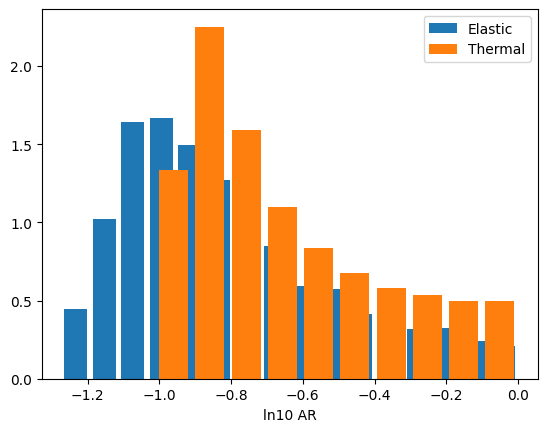

In [151]:
plt.hist(np.log10(merged_data_elastic["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, label='Elastic')

plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, label='Thermal')

plt.legend()
plt.xlabel('ln10 AR')

NameError: name 'merged_data' is not defined

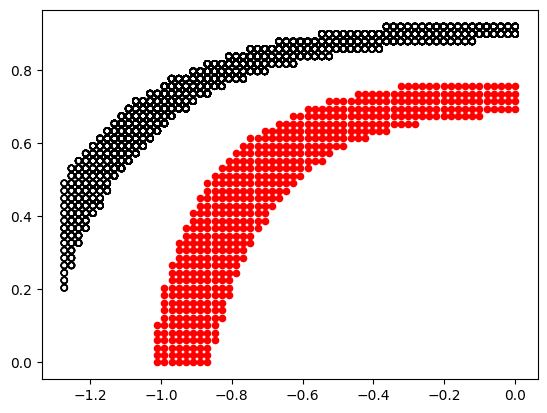

In [147]:
plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')


plt.scatter(np.log10(merged_data_elastic["AR inclusion"]),  merged_data_elastic["f_air"], alpha=0.8,
            s=20, label='Elastic',
            facecolors='none', edgecolors='black')

plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', s=40, label='Electrical')


plt.xlabel('ln10 AR')
plt.ylabel('f')
plt.grid()
plt.legend()

# plt.ylim(0, 0.2)